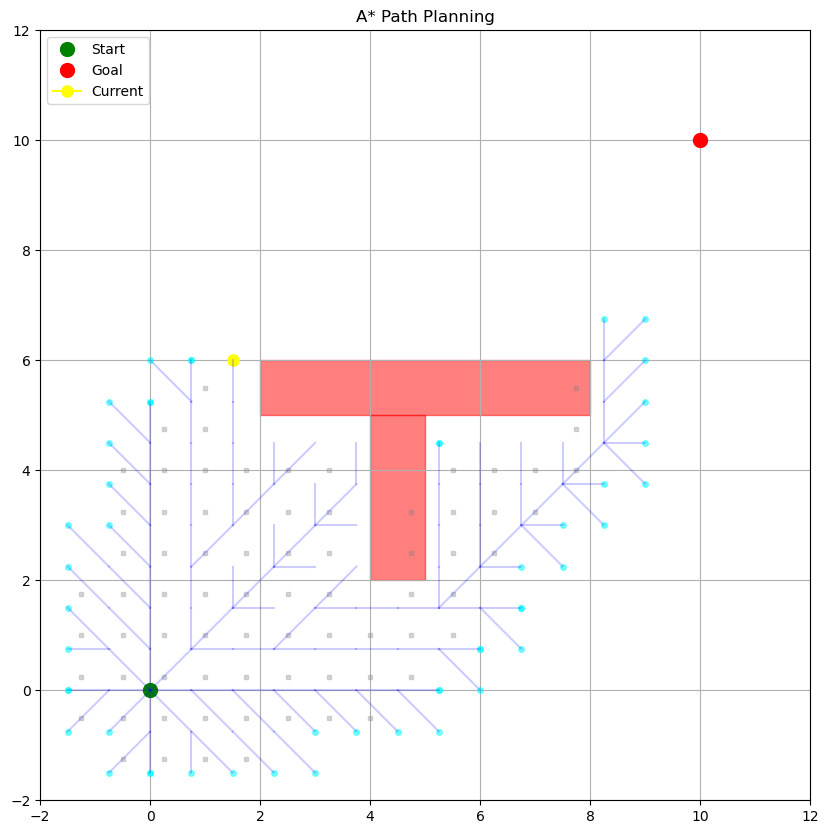

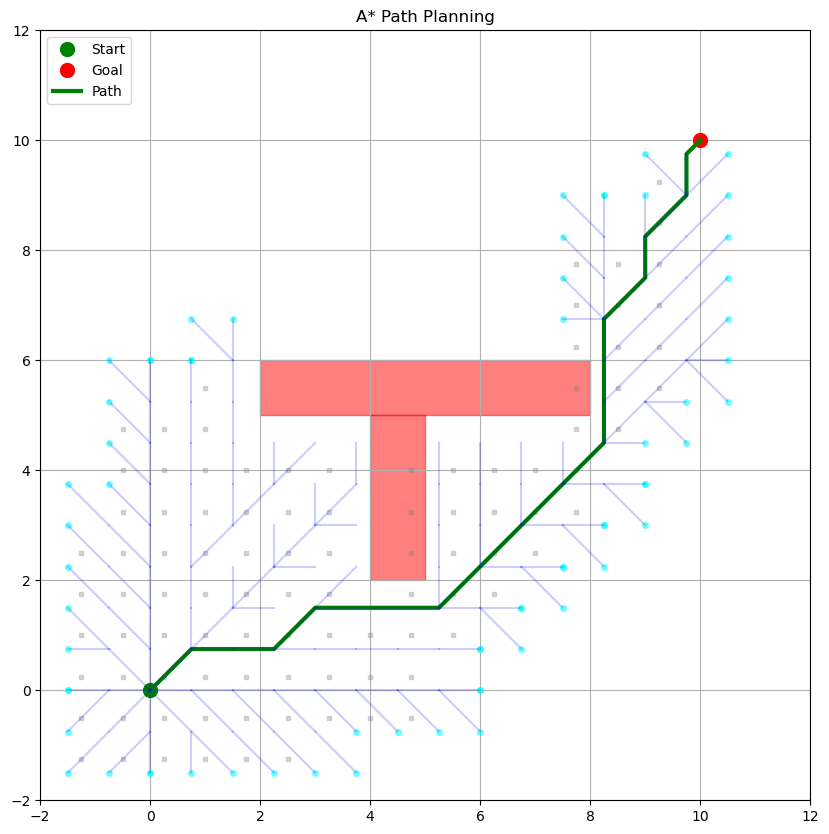

A* found path in 127 iterations!
Path length: 20 points


KeyError: (16, 16)

In [13]:
import math
import heapq
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Tuple, Optional
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()

@dataclass
class Node:
    """Node for A* algorithm"""
    x: float
    y: float
    parent: Optional['Node'] = None
    g: float = 0.0  # Cost from start to current node
    h: float = 0.0  # Heuristic cost to goal
    f: float = 0.0  # Total cost (g + h)
    
    def __lt__(self, other):
        return self.f < other.f

@dataclass
class Obstacle:
    """Rectangular obstacle"""
    x: float
    y: float
    width: float
    height: float
    
    def contains(self, point: Tuple[float, float]) -> bool:
        px, py = point
        return (self.x <= px <= self.x + self.width and 
                self.y <= py <= self.y + self.height)
    
    def plot(self, ax):
        """Plot the obstacle"""
        rect = plt.Rectangle((self.x, self.y), self.width, self.height, 
                            color='red', alpha=0.5)
        ax.add_patch(rect)

class AStar:
    def __init__(self, grid_resolution=0.5, max_iterations=10000):
        self.grid_resolution = grid_resolution
        self.max_iterations = max_iterations
        self.search_space = (-2, -2, 12, 12)  # x_min, y_min, x_max, y_max
        
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        
        self.nodes = {}  # Grid position -> Node mapping
        self.open_set = []  # Priority queue for nodes to explore
        self.closed_set = set()  # Set of explored nodes
        self.obstacles = []
        self.path = []
        
        # Grid boundaries
        self.x_min = self.search_space[0]
        self.x_max = self.search_space[2]
        self.y_min = self.search_space[1]
        self.y_max = self.search_space[3]
        
        # Pre-compute grid dimensions
        self.grid_width = int((self.x_max - self.x_min) / self.grid_resolution)
        self.grid_height = int((self.y_max - self.y_min) / self.grid_resolution)
    
    def add_obstacle(self, obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)
    
    def point_to_grid(self, x: float, y: float) -> Tuple[int, int]:
        """Convert continuous coordinates to grid coordinates"""
        grid_x = int((x - self.x_min) / self.grid_resolution)
        grid_y = int((y - self.y_min) / self.grid_resolution)
        return (grid_x, grid_y)
    
    def grid_to_point(self, grid_x: int, grid_y: int) -> Tuple[float, float]:
        """Convert grid coordinates to continuous coordinates"""
        x = self.x_min + grid_x * self.grid_resolution
        y = self.y_min + grid_y * self.grid_resolution
        return (x, y)
    
    def euclidean_distance(self, x1: float, y1: float, x2: float, y2: float) -> float:
        """Calculate Euclidean distance between two points"""
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    def is_valid_point(self, x: float, y: float) -> bool:
        """Check if point is within bounds and not in obstacle"""
        # Check bounds
        if not (self.x_min <= x <= self.x_max and self.y_min <= y <= self.y_max):
            return False
        
        # Check obstacles
        for obstacle in self.obstacles:
            if obstacle.contains((x, y)):
                return False
        
        return True
    
    def get_neighbors(self, node: Node) -> List[Tuple[float, float]]:
        """Get valid neighboring points (8-connected grid)"""
        neighbors = []
        current_x, current_y = node.x, node.y
        
        # 8-connected neighborhood
        for dx in [-self.grid_resolution, 0, self.grid_resolution]:
            for dy in [-self.grid_resolution, 0, self.grid_resolution]:
                if dx == 0 and dy == 0:
                    continue  # Skip the current point
                
                new_x = current_x + dx
                new_y = current_y + dy
                
                if self.is_valid_point(new_x, new_y):
                    # For diagonal moves, check if the path is clear
                    if dx != 0 and dy != 0:
                        # Check both cardinal directions to avoid cutting corners
                        if (self.is_valid_point(current_x + dx, current_y) and 
                            self.is_valid_point(current_x, current_y + dy)):
                            neighbors.append((new_x, new_y))
                    else:
                        neighbors.append((new_x, new_y))
        
        return neighbors
    
    def collision_free(self, x1: float, y1: float, x2: float, y2: float) -> bool:
        """Check if straight line path is collision-free"""
        # Check multiple points along the line
        steps = max(int(self.euclidean_distance(x1, y1, x2, y2) / self.grid_resolution), 1)
        
        for i in range(steps + 1):
            t = i / steps
            x = x1 + t * (x2 - x1)
            y = y1 + t * (y2 - y1)
            
            if not self.is_valid_point(x, y):
                return False
        
        return True
    
    def plot_search(self, start_node: Node, goal_node: Node, current_node: Node = None, 
                    final_path: bool = False):
        """Visualize the A* search progress"""
        self.ax.clear()
        
        # Set up the plot
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        # Plot start and goal
        self.ax.plot(start_node.x, start_node.y, 'go', markersize=10, label='Start')
        self.ax.plot(goal_node.x, goal_node.y, 'ro', markersize=10, label='Goal')
        
        # Plot obstacles
        for obstacle in self.obstacles:
            obstacle.plot(self.ax)
        
        # Plot explored nodes (closed set)
        for grid_pos in self.closed_set:
            x, y = self.grid_to_point(grid_pos[0], grid_pos[1])
            self.ax.plot(x, y, 'gray', marker='s', markersize=3, alpha=0.3)
        
        # Plot open set nodes
        for _, node in self.open_set:
            grid_pos = self.point_to_grid(node.x, node.y)
            if grid_pos not in self.closed_set:
                self.ax.plot(node.x, node.y, 'cyan', marker='o', markersize=4, alpha=0.5)
        
        # Plot current node being explored
        if current_node:
            self.ax.plot(current_node.x, current_node.y, 'yellow', marker='o', 
                        markersize=8, label='Current')
        
        # Plot the final path if requested
        if final_path and self.path:
            path_x = [p[0] for p in self.path]
            path_y = [p[1] for p in self.path]
            self.ax.plot(path_x, path_y, 'g-', linewidth=3, label='Path')
        
        # Plot parent connections
        for node in self.nodes.values():
            if node.parent:
                parent_x, parent_y = node.parent.x, node.parent.y
                self.ax.plot([node.x, parent_x], [node.y, parent_y], 'b-', alpha=0.2)
        
        plt.title("A* Path Planning")
        plt.legend(loc='upper left')
        plt.draw()
        plt.pause(0.01)
    
    def build_path(self, node: Node) -> List[Tuple[float, float]]:
        """Build the path from start to goal"""
        path = []
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]  # Reverse to get start-to-goal order
    
    def run_astar(self, start_position: List[float], goal_position: List[float]) -> Tuple[bool, int]:
        """Run A* algorithm"""
        # Create start and goal nodes
        start_node = Node(start_position[0], start_position[1])
        goal_node = Node(goal_position[0], goal_position[1])
        
        # Validate start and goal positions
        if not self.is_valid_point(start_node.x, start_node.y):
            print("Start position is invalid!")
            return False, 0
        
        if not self.is_valid_point(goal_node.x, goal_node.y):
            print("Goal position is invalid!")
            return False, 0
        
        # Initialize start node
        start_node.h = self.euclidean_distance(start_node.x, start_node.y, 
                                              goal_node.x, goal_node.y)
        start_node.f = start_node.g + start_node.h
        
        # Add start node to open set
        heapq.heappush(self.open_set, (start_node.f, start_node))
        start_grid = self.point_to_grid(start_node.x, start_node.y)
        self.nodes[start_grid] = start_node
        
        iterations = 0
        
        while self.open_set and iterations < self.max_iterations:
            iterations += 1
            
            # Get node with lowest f value
            current_f, current_node = heapq.heappop(self.open_set)
            current_grid = self.point_to_grid(current_node.x, current_node.y)
            
            # Skip if already processed
            if current_grid in self.closed_set:
                continue
            
            # Add to closed set
            self.closed_set.add(current_grid)
            
            # Visualize every 50 iterations
            if iterations % 50 == 0:
                self.plot_search(start_node, goal_node, current_node)
            
            # Check if goal reached
            if self.euclidean_distance(current_node.x, current_node.y, 
                                      goal_node.x, goal_node.y) <= self.grid_resolution:
                # Connect to goal if path is clear
                if self.collision_free(current_node.x, current_node.y, 
                                      goal_node.x, goal_node.y):
                    goal_node.parent = current_node
                    self.path = self.build_path(goal_node)
                    self.plot_search(start_node, goal_node, final_path=True)
                    return True, iterations
            
            # Explore neighbors
            neighbors = self.get_neighbors(current_node)
            
            for neighbor_pos in neighbors:
                neighbor_x, neighbor_y = neighbor_pos
                neighbor_grid = self.point_to_grid(neighbor_x, neighbor_y)
                
                # Skip if already in closed set
                if neighbor_grid in self.closed_set:
                    continue
                
                # Calculate tentative g score
                tentative_g = current_node.g + self.euclidean_distance(
                    current_node.x, current_node.y, neighbor_x, neighbor_y)
                
                # Create new node or update existing one
                if neighbor_grid not in self.nodes:
                    neighbor_node = Node(neighbor_x, neighbor_y)
                    self.nodes[neighbor_grid] = neighbor_node
                else:
                    neighbor_node = self.nodes[neighbor_grid]
                
                # If this is a better path to this node
                if tentative_g < neighbor_node.g or neighbor_node.g == 0:
                    neighbor_node.parent = current_node
                    neighbor_node.g = tentative_g
                    neighbor_node.h = self.euclidean_distance(
                        neighbor_x, neighbor_y, goal_node.x, goal_node.y)
                    neighbor_node.f = neighbor_node.g + neighbor_node.h
                    
                    # Add to open set
                    heapq.heappush(self.open_set, (neighbor_node.f, neighbor_node))
        
        # No path found
        self.plot_search(start_node, goal_node, final_path=False)
        return False, iterations

# Example usage
if __name__ == "__main__":
    # Create A* planner
    astar = AStar(grid_resolution=0.75, max_iterations=5000)
    
    # Add obstacles (same as your RRT example)
    astar.add_obstacle(Obstacle(4, 2, 1, 3))
    astar.add_obstacle(Obstacle(2, 5, 6, 1))
    
    # Run A* from start to goal
    success, iterations = astar.run_astar([0, 0], [10, 10])
    
    if success:
        print(f"A* found path in {iterations} iterations!")
        print(f"Path length: {len(astar.path)} points")
        print(f"Path cost: {astar.nodes[astar.point_to_grid(10, 10)].g:.2f}")
    else:
        print(f"A* failed to find path after {iterations} iterations.")
    
    plt.show()

In [15]:
class GridAStar:
    def __init__(self, grid_resolution=0.5, max_iterations=10000):
        self.grid_resolution = grid_resolution
        self.max_iterations = max_iterations
        self.search_space = (-2, -2, 12, 12)
        
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        
        self.obstacles = []
        self.path = []
        
        # Grid boundaries
        self.x_min, self.y_min, self.x_max, self.y_max = self.search_space
        
        # Create the entire grid upfront
        self.grid_width = int((self.x_max - self.x_min) / self.grid_resolution)
        self.grid_height = int((self.y_max - self.y_min) / self.grid_resolution)
        
        # Initialize grid with all nodes
        self.grid = [[None for _ in range(self.grid_height)] 
                    for _ in range(self.grid_width)]

    def add_obstacle(self, obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)
    
    def initialize_grid(self):
        """Create all grid nodes upfront"""
        for x in range(self.grid_width):
            for y in range(self.grid_height):
                world_x = self.x_min + x * self.grid_resolution
                world_y = self.y_min + y * self.grid_resolution
                
                # Check if this cell is valid
                is_valid = self.is_valid_point(world_x, world_y)
                self.grid[x][y] = Node(world_x, world_y)
                if not is_valid:
                    # Mark invalid nodes as obstacles
                    self.grid[x][y].f = float('inf')
    
    def is_valid_point(self, x: float, y: float) -> bool:
        """Check if point is within bounds and not in obstacle"""
        if not (self.x_min <= x <= self.x_max and self.y_min <= y <= self.y_max):
            return False
        
        for obstacle in self.obstacles:
            if obstacle.contains((x, y)):
                return False
        
        return True
    
    def point_to_grid(self, x: float, y: float) -> Tuple[int, int]:
        """Convert continuous coordinates to grid indices"""
        grid_x = int((x - self.x_min) / self.grid_resolution)
        grid_y = int((y - self.y_min) / self.grid_resolution)
        
        # Clamp to grid boundaries
        grid_x = max(0, min(grid_x, self.grid_width - 1))
        grid_y = max(0, min(grid_y, self.grid_height - 1))
        
        return (grid_x, grid_y)
    
    def grid_to_point(self, grid_x: int, grid_y: int) -> Tuple[float, float]:
        """Convert grid indices to continuous coordinates"""
        x = self.x_min + grid_x * self.grid_resolution
        y = self.y_min + grid_y * self.grid_resolution
        return (x, y)
    
    def get_neighbors(self, grid_x: int, grid_y: int) -> List[Tuple[int, int]]:
        """Get valid neighboring grid cells (8-connected)"""
        neighbors = []
        
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                
                new_x, new_y = grid_x + dx, grid_y + dy
                
                # Check bounds
                if 0 <= new_x < self.grid_width and 0 <= new_y < self.grid_height:
                    neighbor_node = self.grid[new_x][new_y]
                    
                    # Skip if obstacle (infinite cost)
                    if neighbor_node.f != float('inf'):
                        # For diagonal moves, check if adjacent cells are clear
                        if dx != 0 and dy != 0:
                            # Check both cardinal neighbors
                            if (self.grid[grid_x + dx][grid_y].f != float('inf') and 
                                self.grid[grid_x][grid_y + dy].f != float('inf')):
                                neighbors.append((new_x, new_y))
                        else:
                            neighbors.append((new_x, new_y))
        
        return neighbors
    
    def plot_grid(self, start_node: Node, goal_node: Node, 
                  open_set: List, closed_set: Set, current_node: Node = None,
                  final_path: bool = False):
        """Visualize the grid and search progress"""
        self.ax.clear()
        
        # Set up plot
        self.ax.set_xlim(self.x_min, self.x_max)
        self.ax.set_ylim(self.y_min, self.y_max)
        self.ax.set_aspect('equal')
        self.ax.grid(True, which='both', alpha=0.3)
        
        # Draw grid lines
        for x in range(self.grid_width + 1):
            self.ax.axvline(self.x_min + x * self.grid_resolution, 
                           color='gray', alpha=0.2, linewidth=0.5)
        for y in range(self.grid_height + 1):
            self.ax.axhline(self.y_min + y * self.grid_resolution,
                           color='gray', alpha=0.2, linewidth=0.5)
        
        # Plot obstacles (invalid cells)
        for x in range(self.grid_width):
            for y in range(self.grid_height):
                node = self.grid[x][y]
                if node.f == float('inf'):  # Obstacle cell
                    self.ax.fill_between([node.x, node.x + self.grid_resolution],
                                        node.y, node.y + self.grid_resolution,
                                        color='red', alpha=0.3)
        
        # Plot start and goal
        self.ax.plot(start_node.x, start_node.y, 'go', markersize=12, label='Start', zorder=5)
        self.ax.plot(goal_node.x, goal_node.y, 'ro', markersize=12, label='Goal', zorder=5)
        
        # Plot closed set (explored cells)
        for (gx, gy) in closed_set:
            node = self.grid[gx][gy]
            self.ax.add_patch(plt.Rectangle(
                (node.x, node.y), self.grid_resolution, self.grid_resolution,
                color='gray', alpha=0.3, zorder=1))
        
        # Plot open set (frontier cells)
        for _, (gx, gy) in open_set:
            node = self.grid[gx][gy]
            self.ax.add_patch(plt.Rectangle(
                (node.x, node.y), self.grid_resolution, self.grid_resolution,
                color='cyan', alpha=0.3, zorder=2))
        
        # Plot current node
        if current_node:
            self.ax.plot(current_node.x, current_node.y, 'yellow', marker='s',
                        markersize=8, label='Current', zorder=6)
        
        # Plot final path
        if final_path and self.path:
            path_x = [p[0] for p in self.path]
            path_y = [p[1] for p in self.path]
            self.ax.plot(path_x, path_y, 'g-', linewidth=3, label='Path', zorder=4)
            
            # Also highlight path cells
            for point in self.path:
                gx, gy = self.point_to_grid(point[0], point[1])
                node = self.grid[gx][gy]
                self.ax.add_patch(plt.Rectangle(
                    (node.x, node.y), self.grid_resolution, self.grid_resolution,
                    color='green', alpha=0.2, zorder=3))
        
        plt.title("Grid-Based A* Path Planning")
        plt.legend(loc='upper left')
        plt.draw()
        plt.pause(0.01)
    
    def run_astar(self, start_position: List[float], goal_position: List[float]) -> Tuple[bool, int]:
        """Run grid-based A* algorithm"""
        # Convert to grid coordinates
        self.initialize_grid()
        start_gx, start_gy = self.point_to_grid(start_position[0], start_position[1])
        goal_gx, goal_gy = self.point_to_grid(goal_position[0], goal_position[1])
        
        # Get start and goal nodes
        start_node = self.grid[start_gx][start_gy]
        goal_node = self.grid[goal_gx][goal_gy]
        
        # Check validity
        if start_node.f == float('inf'):
            print("Start position is in obstacle!")
            return False, 0
        if goal_node.f == float('inf'):
            print("Goal position is in obstacle!")
            return False, 0
        
        # Initialize start node
        start_node.g = 0
        start_node.h = self.euclidean_distance(start_node.x, start_node.y,
                                              goal_node.x, goal_node.y)
        start_node.f = start_node.g + start_node.h
        
        # Initialize open and closed sets
        open_set = []  # Priority queue of (f, (grid_x, grid_y))
        closed_set = set()  # Set of visited grid positions
        
        heapq.heappush(open_set, (start_node.f, (start_gx, start_gy)))
        
        iterations = 0
        
        while open_set and iterations < self.max_iterations:
            iterations += 1
            
            # Get node with lowest f value
            current_f, (current_gx, current_gy) = heapq.heappop(open_set)
            current_node = self.grid[current_gx][current_gy]
            
            # Skip if already processed
            if (current_gx, current_gy) in closed_set:
                continue
            
            # Add to closed set
            closed_set.add((current_gx, current_gy))
            
            # Visualize every 50 iterations
            if iterations % 50 == 0:
                self.plot_grid(start_node, goal_node, open_set, closed_set, current_node)
            
            # Check if goal reached
            if current_gx == goal_gx and current_gy == goal_gy:
                self.path = self.build_path(current_node)
                self.plot_grid(start_node, goal_node, open_set, closed_set, 
                              current_node, final_path=True)
                return True, iterations
            
            # Explore neighbors
            neighbors = self.get_neighbors(current_gx, current_gy)
            
            for (neighbor_gx, neighbor_gy) in neighbors:
                # Skip if already closed
                if (neighbor_gx, neighbor_gy) in closed_set:
                    continue
                
                neighbor_node = self.grid[neighbor_gx][neighbor_gy]
                
                # Calculate tentative g score
                # Use 1.414 for diagonal moves, 1 for cardinal moves
                move_cost = 1.414 if (abs(neighbor_gx - current_gx) == 1 and 
                                     abs(neighbor_gy - current_gy) == 1) else 1
                tentative_g = current_node.g + move_cost
                
                # Check if this is a better path
                if tentative_g < neighbor_node.g or neighbor_node.g == 0:
                    neighbor_node.parent = current_node
                    neighbor_node.g = tentative_g
                    neighbor_node.h = self.euclidean_distance(
                        neighbor_node.x, neighbor_node.y, 
                        goal_node.x, goal_node.y)
                    neighbor_node.f = neighbor_node.g + neighbor_node.h
                    
                    # Add to open set if not already there
                    heapq.heappush(open_set, (neighbor_node.f, (neighbor_gx, neighbor_gy)))
        
        # No path found
        self.plot_grid(start_node, goal_node, open_set, closed_set, final_path=False)
        return False, iterations
    
    def euclidean_distance(self, x1: float, y1: float, x2: float, y2: float) -> float:
        """Calculate Euclidean distance"""
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    def build_path(self, node: Node) -> List[Tuple[float, float]]:
        """Build path from goal to start"""
        path = []
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]

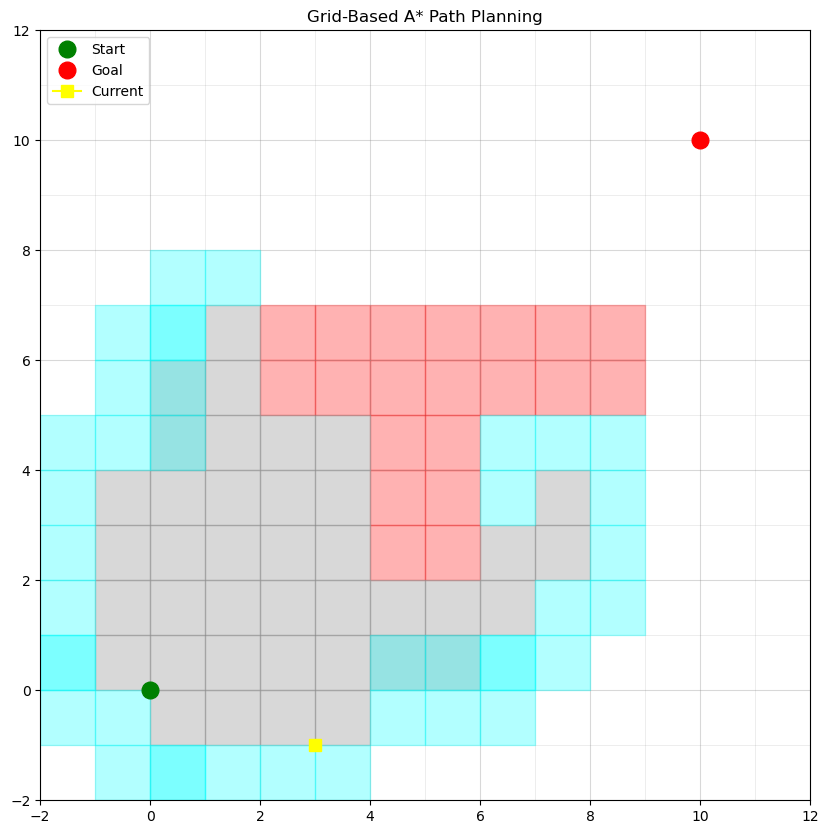

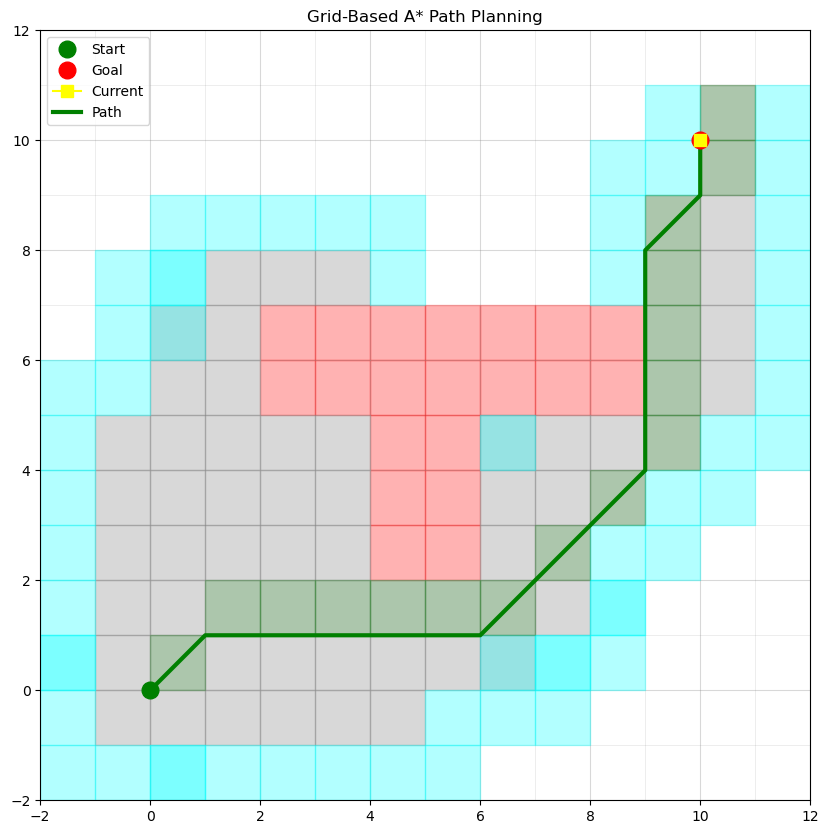

A* found path in 79 iterations!
Path length: 16 points


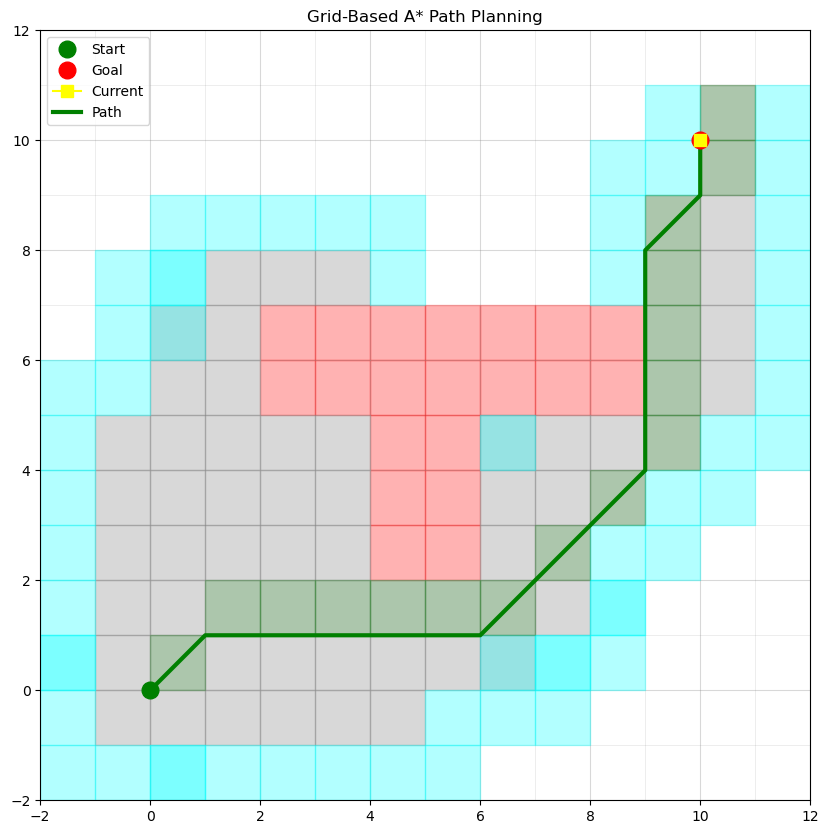

In [25]:
if __name__ == "__main__":
    # Create A* planner
    astar = GridAStar(grid_resolution=1, max_iterations=5000)
    
    # Add obstacles (same as your RRT example)
    astar.add_obstacle(Obstacle(4, 2, 1, 3))
    astar.add_obstacle(Obstacle(2, 5, 6, 1))
    
    # Run A* from start to goal
    success, iterations = astar.run_astar([0, 0], [10, 10])
    
    if success:
        print(f"A* found path in {iterations} iterations!")
        print(f"Path length: {len(astar.path)} points")
        # print(f"Path cost: {astar.nodes[astar.point_to_grid(10, 10)].g:.2f}")
    else:
        print(f"A* failed to find path after {iterations} iterations.")
    
    plt.show()